In [5]:
import numpy as np
from findiff import FinDiff
import matplotlib.pyplot as plt

"""
Using first order approximation for first derivative
"""
M = 1
Q = 0.9  
b = 200
p = 2.116895853824
n = 2**(12) # Defining the number of grid points
a = 0  # Dissipation coefficient for Kriess oliger dissipation scheme

err = 10**(-3)
Z = np.linspace(err, 1 - err, n)
R = M* Z/(1 - Z)
dz = 1/n

# Defining the derivative operator
d_dz = FinDiff(0, dz, 1, acc=4)

# Defining the phi at t=0
phi = np.zeros(n)

for i in range(0, n):
        expo = Z[i]**2 / ( p**2 * (1 - Z[i])**2 )
        if expo <= 100 :
            phi[i] = 0.5 * np.exp(- expo)

dphi = d_dz(phi)/d_dz(R)
drdz = d_dz(R)

def f(x):
    return np.exp(b* x**4)

# Defining the coupling function
fphi = f(phi)

Y = np.zeros(4)
Y[3] = 2* M

# Performing finite difference using first order difference (Eulers Method)

for i in range(0, 3):
    Y[2 - i] = Y[3 - i] - dz* (drdz[n - 1 - i] * R[n - 1 - i]**2 )* (dphi[n - 1 - i]**2 + Q**2 / (R[n - 1 - i]**4 * fphi[n - 1 - i]))


# Using Fourth order finite difference by borrowing first 3 points from the Euler Method data
Y4 = np.zeros(n)

# Defining the initial conditions from the Eulers Method 
Y4[n - 1] = Y[3]
Y4[n - 2] = Y[2]
Y4[n - 3] = Y[1]
Y4[n - 4] = Y[0]

for i in range(0, n - 4):
    term = drdz[n - 5 - i] * R[n - 5 - i]**2 * (dphi[n - 5 - i]**2 + Q**2 / (R[n - 5 - i]**4 * fphi[n - 5 - i]) )
                                                 
    Y4[n - i - 5] = (term * 12 * dz - ( (48 - 104*a*dz) * Y4[n - i - 4] - (36 - 114*a*dz) * Y4[n - i - 3] + (16 - 56*a*dz) * Y4[n - i - 2] - (3 - 11*a*dz)* Y4[n - i - 1]) )  / (-25 + 35*a*dz)

    # print(Y4[n - i - 5])


cut_off1 = np.argmin(abs(Y4 - R))//10 * 10
zeta1 =  np.sqrt(Y4[cut_off1:]/R[cut_off1:])
z1 = Z[cut_off1:]
print(cut_off1)

2320


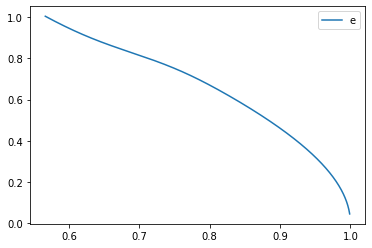

In [6]:
plt.plot(z1, zeta1, label='e')
plt.legend()
plt.show()


 The position of initial apparant horizon is r = 1.30633411149816 
 z = 0.5664114774114775 
 m = 2320
2320


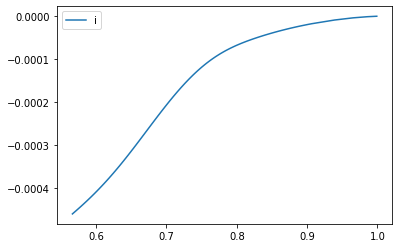

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt 
from scipy.linalg import solve_banded
from scipy.optimize import root
import sys
sys.path.insert(0,'.')
import pandas as pd

# We will try to solve for the function zeta using implict method and compare our answer to the one obtained through backward differenc
# Kriess Oliger Dissipation function has also been employed

def round_of_to_lowest_ten(x):
    return (x // 10)* 10 

def get_banded_form(matrix, bandwidth_up, bandwidth_down):
    n = matrix.shape[0]
    diagonals = np.zeros((bandwidth_up + bandwidth_down + 1, n))

    for i in range(-bandwidth_down, bandwidth_up + 1):
        for j in range(0, n - abs(i)):
            if i >= 0:
                diagonals[bandwidth_up - i, n - 1 -j] = np.diag(matrix, k = i)[n - abs(i) - 1 - j]
            else:
                diagonals[bandwidth_up - i, j] = np.diag(matrix, k = i)[j]
    return diagonals


m = 1
Q = 0.9
p = 2.116895853824
A = 0.5
b_couple = 200
y_boundary =2* m 
a = 0.1                      # Kreiss Oliger Dissipation coefficient
h = 1/2**12                   # Step size
n = 2**12 - 1                 # We only solve for the points which are not initially fixed

# Definiing the implicit matrix
M = np.zeros([n, n])

# Defining the boundary parts of matrix 
M[0, :5]         = [-25 + 12 * a * h * 35, 48 + 12 * a * h * (-104), -36 + 12 * a * h * 114, 16 + 12 * a * h * (-56), -3 + 12 * a * h * 11]
M[1, :5]         = [-3 + 12 * a * h * 11, -10 + 12 * a * h * (-20), 18 + 12 * a * h * 6, -6 + 12 * a * h * 4, 1 + 12 * a * h * (-1)]
M[n - 2, n - 4:] = [1 + 12 * a * h * (-1), -8 + 12 * a * h * 16, 0 + 12 * a * h * (-30), 8 + 12 * a * h * 16]
M[n - 1, n - 4:] = [-1 + 12 * a * h * (-1), 6 + 12 * a * h * 4, -18 + 12 * a * h * 6, 10 + 12 * a * h * (-20)]

# Bulk of the matrix
for i in range(2, n - 2):       
    M[i][i - 2] = 1 + 12* a* h* (-1)
    M[i][i - 1] = -8 + 12* a* h* (16)
    M[i][i]     = 0 + 12* a* h* (-30) 
    M[i][i + 1] = 8 + 12* a* h* (16)
    M[i][i + 2] = -1 + 12* a* h* (-1)

err = 10**(-3)
Z = np.linspace(err, 1 - err, 2**(12))

Z_mod = Z[:-1]      # Neglecting the final point
b = np.zeros(n)

for i in range(0, n):
    c1 = Q**2 / (m* Z_mod[i]**2)
    c2 = 4* A**2* m* Z_mod[i]**4 / (p**4 * (Z_mod[i] - 1)**6 )

    int1 = np.exp(- 4* Z_mod[i]**2 / (p**2* (Z_mod[i] - 1)**2 ))
    int2 = np.exp(- 2* Z_mod[i]**2 / (p**2* (Z_mod[i] - 1)**2 ))

    term1 = c1* np.exp( - A**4* b_couple* int1 ) 
    term2 = c2* int2
    term = term1 + term2    
    b[i] = term* 12* h


# Fixing initial conditions
b[n - 1] = b[n - 1] - ((3 + 11* 12*a*h)* y_boundary) 
b[n - 2] = b[n - 2] - ((-1 - 1* 12*a*h)* y_boundary) 


# Using banded technique
banded_M = get_banded_form(M, 4, 3)
Y = solve_banded((3, 4), banded_M, b)

Y_mod = np.append(Y, y_boundary)
R = m* Z/(1 - Z)

cut_off = round_of_to_lowest_ten(np.argmin(abs(Y_mod - R)))

print(f" The position of initial apparant horizon is r = {R[cut_off]} \n z = {Z[cut_off]} \n m = {cut_off}") 
print(cut_off)
m = n - cut_off + 1
s = np.sqrt(Y_mod[cut_off:])
r = R[cut_off:]
z = Z[cut_off:]

plt.plot(z, s/np.sqrt(r), label='i')
plt.plot(z1, zeta1, label='e')
plt.legend()
plt.show()
